In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

In [159]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")

In [187]:
from torch import nn
import torch.nn.functional as F
from gymnasium import spaces
import numpy as np
from tqdm import tqdm

class TDLambda(nn.Module):
    def __init__(self, env, lam: float = 0.9, discount: float = 0.95, alpha: float = 0.15, action_size = 3, observation_size = 2):
        self.lam = lam
        self.discount = discount
        self.alpha = alpha

        # environment specific vars
        self.action_space = spaces.Discrete(action_size)
        self.action_size = action_size
        self.observation_size = observation_size
        
        self.env = env

        # metrics 
        self.actions = []
        self.rewards = []
        self.observations = []

        self.E = {}
        self.V = {}

        self.policy = {}

    def init_policy(self):
        for i in np.linspace(-1.2, 0.6, 19, dtype=np.float32):
            for j in np.linspace(-0.07, 0.07, 15, dtype=np.float32):
                self.policy[(i, j)] = [[], [], []]

    def train(self, total_steps: int = 5000):
        self.init_policy()
        self.initialize_values_and_traces()
        obs = self.env.reset()
        arr = self.env.render()
        plt.imshow(arr)
        obs = obs[0]
        self.observations.append(obs)
        self.rewards.append(0)

        action = None
        dones = 0

        for step in tqdm(range(total_steps), desc="training td-lambda"):
            action = self.choose_action()
            prevobs = obs
            print(prevobs)
            obs, rew, done, trunc, info = self.env.step(action)
            td = rew + self.discount * self.value(obs) - self.value(prevobs)
            self.eligibility_trace(prevobs)

            for s in self.V.keys():
                self.V[s] = self.V[s] + self.alpha * td * self.E[s]
                self.E[s] = self.discount * self.lam * self.E[s]

            self.policy[(np.round(prevobs[0], 1), np.round(prevobs[1], 2))][action].append(self.rewards[-1] + self.discount * self.value(obs))

            self.observations.append(obs)
            self.rewards.append(rew)
            self.actions.append(action)

            if done or trunc:
                dones+=1
                self.reset_traces()
                obs = self.env.reset()
                obs = obs[0]
                self.rewards.append(0)
                self.observations.append(obs)
                arr = self.env.render()
                plt.imshow(arr)
            
        print(dones)


    def eval(self, episodes: int = 5):
        obs = self.env.reset()[0]
        rewards = []
        actions = []
        cur_reward = 0

        for e in range(episodes):
            while True:
                action_list = list(map(np.mean, self.policy[(np.round(obs[0], 1), np.round(obs[1], 2))]))
                action = np.argmax(list(map(np.mean, self.policy[(np.round(obs[0], 1), np.round(obs[1], 2))])))
                # print(action)
                actions.append(action)
                obs, rew, done, trunc, info = self.env.step(action)
                cur_reward+=rew
                if done or trunc:
                    rewards.append(cur_reward)
                    cur_reward = 0
                    obs = env.reset()[0]
                    break

        return rewards, actions


    def initialize_values_and_traces(self):
        for i in np.linspace(-1.2, 0.6, 19, dtype=np.float32):
            for j in np.linspace(-0.07, 0.07, 15, dtype=np.float32):
                if i>=0.5: 
                    self.V[(i, j)] = 0
                    self.E[(i, j)] = 0
                    continue
                self.V[(i, j)] = np.random.random_sample()
                self.E[(i, j)] = 0
    

    def reset_traces(self):
        for i in np.linspace(-1.2, 0.6, 19, dtype=np.float32):
            for j in np.linspace(-0.07, 0.07, 15, dtype=np.float32):
                if i>=0.5: 
                    self.E[(i, j)] = 0
                    continue
                self.E[(i, j)] = 0


    def eligibility_trace(self, state):
        pos = np.round(state[0], 1)
        vel = np.round(state[1], 2)
        value = (pos, vel)
        self.E[value] += 1
        return self.E[value]


    def value(self, state):
        pos = np.round(state[0], 1)
        vel = np.round(state[1], 2)
        value = (pos, vel)
        return self.V[value]


    def choose_action(self):
        return self.action_space.sample()

training td-lambda:  12%|█▏        | 117/1000 [00:00<00:00, 1161.56it/s]

[-0.5617998  0.       ]
[-0.56251395 -0.00071412]
[-5.6293684e-01 -4.2291792e-04]
[-5.6306541e-01 -1.2856677e-04]
[-0.56189865  0.00116674]
[-5.614453e-01  4.533595e-04]
[-0.5597087  0.0017366]
[-0.5587018   0.00100689]
[-5.5843216e-01  2.6968063e-04]
[-5.5890167e-01 -4.6954441e-04]
[-0.56010693 -0.00120527]
[-0.56203896 -0.001932  ]
[-0.5646833  -0.00264434]
[-0.56602025 -0.00133699]
[-5.6603998e-01 -1.9682966e-05]
[-0.5667422  -0.00070223]
[-5.6712174e-01 -3.7956046e-04]
[-0.5681758  -0.00105406]
[-5.6789654e-01  2.7926738e-04]
[-5.6828600e-01 -3.8947634e-04]
[-5.683414e-01 -5.532497e-05]
[-5.680621e-01  2.792376e-04]
[-0.5674504   0.00061172]
[-5.6751072e-01 -6.0336104e-05]
[-0.56824267 -0.00073195]
[-0.5676408   0.00060188]
[-0.56570953  0.00193124]
[-0.56346333  0.00224623]
[-0.5599188  0.0035445]
[-0.55510247  0.00481636]
[-0.5510502   0.00405229]
[-0.5457922   0.00525794]
[-0.54036796  0.00542427]
[-0.535818    0.00454998]
[-0.5311764   0.00464161]
[-0.52547795  0.00569844]
[-0.

training td-lambda:  48%|████▊     | 484/1000 [00:00<00:00, 1214.17it/s]

[-0.6057626  -0.00236905]
[-0.60852164 -0.00275904]
[-0.6106506  -0.00212899]
[-0.6121341  -0.00148349]
[-0.6139614  -0.00182726]
[-6.1411917e-01 -1.5780872e-04]
[-0.6126064   0.00151278]
[-0.610434    0.00217243]
[-0.6066176   0.00381636]
[-0.601185    0.00543258]
[-0.5951758   0.00600924]
[-0.5896338   0.00554195]
[-0.58459985  0.00503398]
[-0.5791109   0.00548894]
[-0.5742076   0.00490336]
[-0.5699261   0.00428147]
[-0.5652983  0.0046278]
[-0.5593586   0.00593974]
[-0.5541512   0.00520742]
[-0.5497149   0.00443624]
[-0.544083    0.00563191]
[-0.53729755  0.00678545]
[-0.5314094   0.00588816]
[-0.52446264  0.00694673]
[-0.5165095   0.00795321]
[-0.5096094   0.00690005]
[-0.50181425  0.00779516]
[-0.49418235  0.00763189]
[-0.4867708   0.00741155]
[-0.4786349  0.0081359]
[-0.4708352  0.0077997]
[-0.46242958  0.00840562]
[-0.45448014  0.00794942]
[-0.4480454   0.00643474]
[-0.44317248  0.00487293]
[-0.43889692  0.00427557]
[-0.43424982  0.00464712]
[-0.43126482  0.002985  ]
[-0.4299635 

training td-lambda:  61%|██████    | 606/1000 [00:00<00:00, 1136.27it/s]

[-0.55339664 -0.01393195]
[-0.5661054  -0.01270876]
[-0.5794962  -0.01339082]
[-0.5924698  -0.01297355]
[-0.6039305  -0.01146069]
[-0.6147945  -0.01086402]
[-0.624983   -0.01018855]
[-0.6344229  -0.00943984]
[-0.6440468  -0.00962388]
[-0.6517868  -0.00774005]
[-0.659589   -0.00780217]
[-0.66539925 -0.0058103 ]
[-0.67117786 -0.00577858]
[-0.6758854  -0.00470755]
[-0.6784901  -0.00260472]
[-6.7897451e-01 -4.8438707e-04]
[-0.6773353   0.00163919]
[-0.67458355  0.00275177]
[-0.67073774  0.00384583]
[-0.66482383  0.00591388]
[-0.65688217  0.00794166]
[-0.64696735  0.00991486]
[-0.6371482   0.00981915]
[-0.62549376  0.01165439]
[-0.612087    0.01340676]
[-0.59802437  0.01406265]
[-0.58240813  0.01561622]
[-0.56535316  0.01705501]
[-0.5479858   0.01736735]
[-0.5314357   0.01655008]
[-0.5158269   0.01560886]
[-0.50027627  0.01555057]
[-0.4859005  0.0143758]
[-0.4728068   0.01309366]
[-0.46009263  0.01271419]
[-0.44885185  0.01124077]
[-0.437167    0.01168486]
[-0.42712313  0.01004386]
[-0.4167

training td-lambda:  83%|████████▎ | 834/1000 [00:00<00:00, 1088.14it/s]

[-0.5661637   0.01688798]
[-0.54895735  0.01720635]
[-0.530561    0.01839636]
[-0.5131124   0.01744857]
[-0.49474248  0.01836994]
[-0.4765887   0.01815378]
[-0.45978633  0.01680238]
[-0.44445962  0.0153267 ]
[-0.4297209   0.01473872]
[-0.416677    0.01304391]
[-0.40442133  0.01225567]
[-0.39404055  0.01038076]
[-0.3836072   0.01043336]
[-0.37519318  0.00841402]
[-0.3678558   0.00733738]
[-0.36164445  0.00621135]
[-0.35760054  0.00404392]
[-0.3537508   0.00384976]
[-0.3521205   0.00163031]
[-0.3507203  0.0014002]
[-0.3495593   0.00116096]
[-3.4964514e-01 -8.5832522e-05]
[-3.4997723e-01 -3.3206798e-04]
[-0.35055336 -0.00057614]
[-0.35336983 -0.00281647]
[-0.35840824 -0.00503841]
[-0.3646355  -0.00622725]
[-0.37101027 -0.00637479]
[-0.37948993 -0.00847965]
[-0.38801706 -0.00852712]
[-0.39753324 -0.00951617]
[-0.4079725  -0.01043928]
[-0.4192617 -0.0112892]
[-0.4313207  -0.01205901]
[-0.443063   -0.01174229]
[-0.45640343 -0.01334045]
[-0.46924445 -0.012841  ]
[-0.4834913  -0.01424686]
[-0.

training td-lambda: 100%|██████████| 1000/1000 [00:00<00:00, 1107.15it/s]


[-0.54706717 -0.0132142 ]
[-0.5591055  -0.01203833]
[-0.570878   -0.01177253]
[-0.58229715 -0.01141913]
[-0.59427834 -0.01198116]
[-0.6067333  -0.01245503]
[-0.6195713  -0.01283796]
[-0.6316994  -0.01212807]
[-0.6430308  -0.01133145]
[-0.6534856  -0.01045476]
[-0.6639907  -0.01050507]
[-0.67347366 -0.00948299]
[-0.68287003 -0.00939642]
[-0.69211686 -0.00924682]
[-0.701153   -0.00903609]
[-0.70891947 -0.00776652]
[-0.7163666  -0.00744711]
[-0.7224472 -0.0060806]
[-0.7271233  -0.00467614]
[-0.7303661  -0.00324279]
[-0.7311557  -0.00078959]
[-0.7294873   0.00166843]
[-0.72737104  0.00211626]
[-0.7248199   0.00255113]
[-0.7218496   0.00297028]
[-0.7164786   0.00537104]
[-0.7087403   0.00773826]
[-0.7006838   0.00805652]
[-0.6913608   0.00932306]
[-0.6798319   0.01152882]
[-0.66617376  0.01365814]
[-0.65247864  0.01369514]
[-0.6368408   0.01563784]
[-0.61936986  0.01747091]
[-0.60219055  0.01717935]
[-0.5844272   0.01776334]
[-0.56621015  0.01821703]
[-0.5476744   0.01853575]
[-0.5279583   

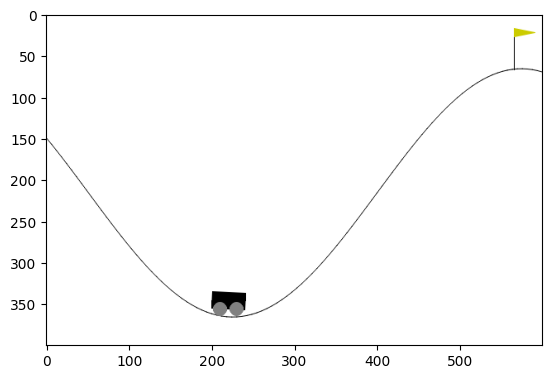

In [188]:
model = TDLambda(env)
model.train(1000000)

In [184]:
rewards, actions = model.eval(100)

ValueError: not enough values to unpack (expected 6, got 5)

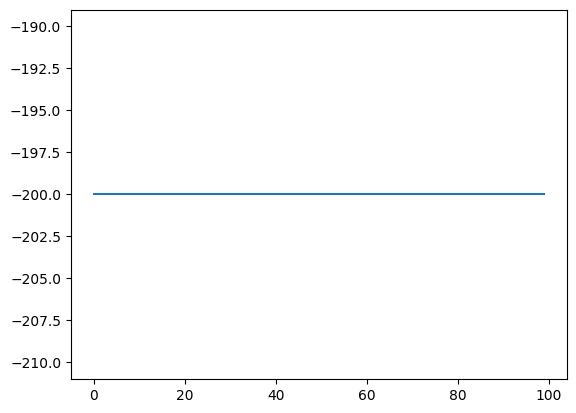

In [173]:
plt.plot(rewards)

In [174]:
model.V

{(-1.2, -0.07): 0.23017414788947044,
 (-1.2, -0.06): 0.6062652710596934,
 (-1.2, -0.05): 0.7973110478801525,
 (-1.2, -0.04): 0.24495546694272163,
 (-1.2, -0.03): 0.08489732001957861,
 (-1.2, -0.02): 0.26083735439936995,
 (-1.2, -0.01): 0.5040852484498516,
 (-1.2, 0.0): 0.39596921706634425,
 (-1.2, 0.01): 0.5330057153421265,
 (-1.2, 0.02): 0.3877633691968855,
 (-1.2, 0.03): 0.836352167476543,
 (-1.2, 0.04): 0.8477949855150191,
 (-1.2, 0.05): 0.8244824257685373,
 (-1.2, 0.06): 0.6446532038200785,
 (-1.2, 0.07): 0.10393730764800846,
 (-1.1, -0.07): 0.3391928322372252,
 (-1.1, -0.06): 0.4762776233802498,
 (-1.1, -0.05): 0.11516266458867952,
 (-1.1, -0.04): 0.9769077458071095,
 (-1.1, -0.03): 0.42499466881598624,
 (-1.1, -0.02): 0.24792267526444478,
 (-1.1, -0.01): 0.2743073001576227,
 (-1.1, 0.0): 0.7089291418699412,
 (-1.1, 0.01): 0.5631786103058569,
 (-1.1, 0.02): 0.8642898689741202,
 (-1.1, 0.03): 0.7239074501502862,
 (-1.1, 0.04): 0.460210271584951,
 (-1.1, 0.05): 0.16156478263173646,
